Iniciando varredura em 'repositories-mined'...


Processando repositórios: 100%|██████████| 13/13 [00:02<00:00,  4.95it/s]
/tmp/ipykernel_9057/1581254327.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='faixa', y='tempo_merge_horas',



Total de PRs coletados: 73325


--- Resumo dos Dados (Ordem E -> A) ---

--- Tempo Médio para Merge por Faixa (em horas) ---
faixa
E    319.27
D    291.56
C    365.60
B    272.71
A    118.17
Name: tempo_merge_horas, dtype: float64

--- Taxa de Sucesso da CI por Faixa ---
faixa
E    0.118
D    0.085
C    0.114
B    0.144
A    0.184
Name: ci_sucesso, dtype: float64

--- Hora Média de Criação ---
faixa
E    12.96
D    13.13
C    12.59
B    12.74
A    13.20
Name: hora_criacao, dtype: float64

--- Dia Médio de Criação (0=Segunda) ---
faixa
E    2.76
D    2.67
C    2.75
B    2.53
A    2.44
Name: dia_semana_criacao, dtype: float64

--- Contagem Total de PRs por Faixa (para referência) ---
faixa
E      195
D      495
C     1619
B     6106
A    64910
dtype: int64

--- Gerando Gráficos de Análise de Eficiência (Ordem E -> A) ---


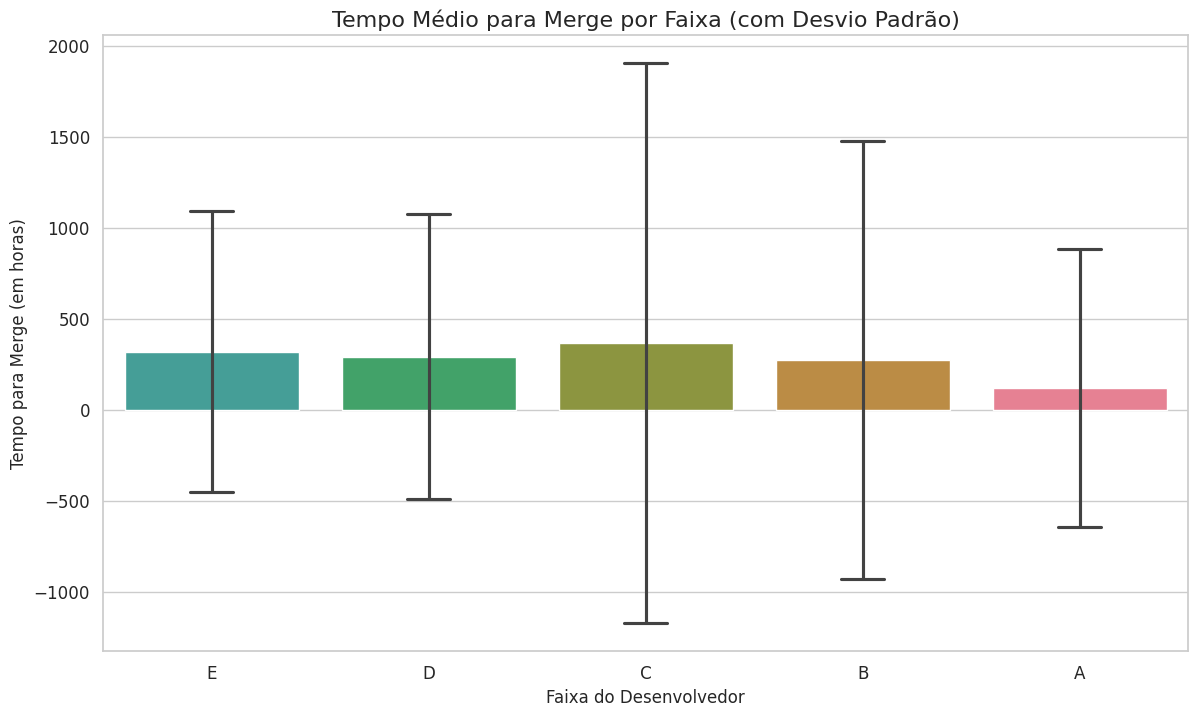

/tmp/ipykernel_9057/1581254327.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_ci.index, y=df_ci.values, palette=paleta_consistente_husl)


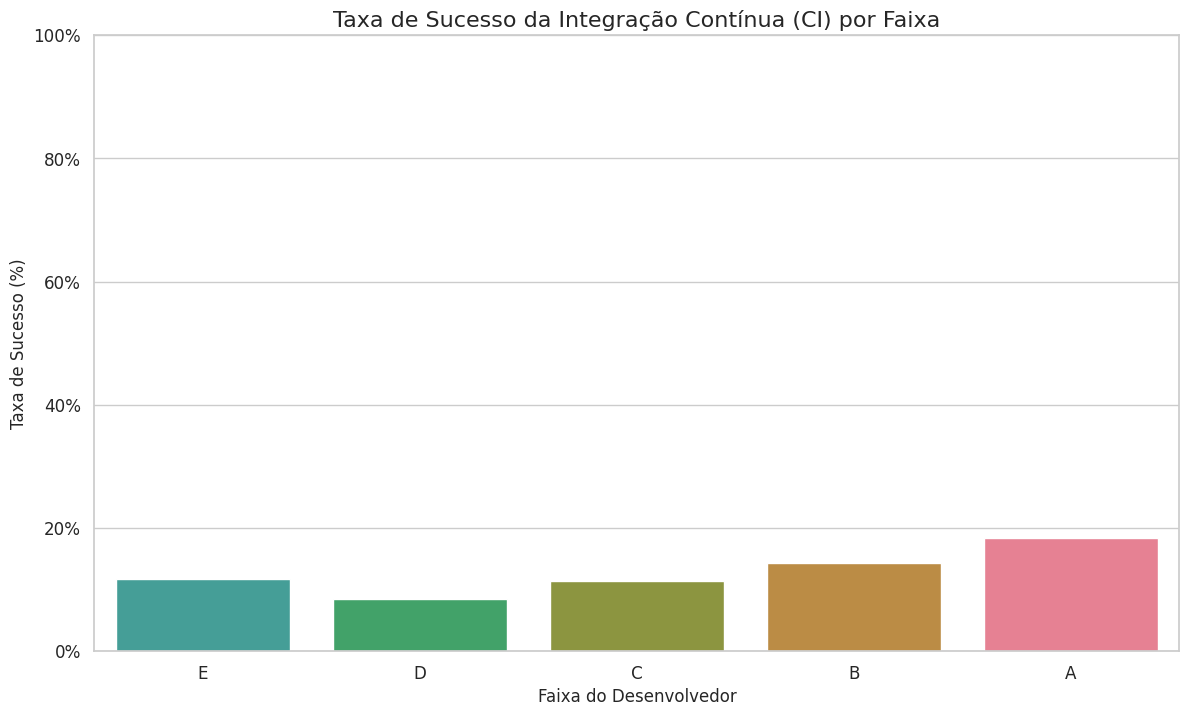

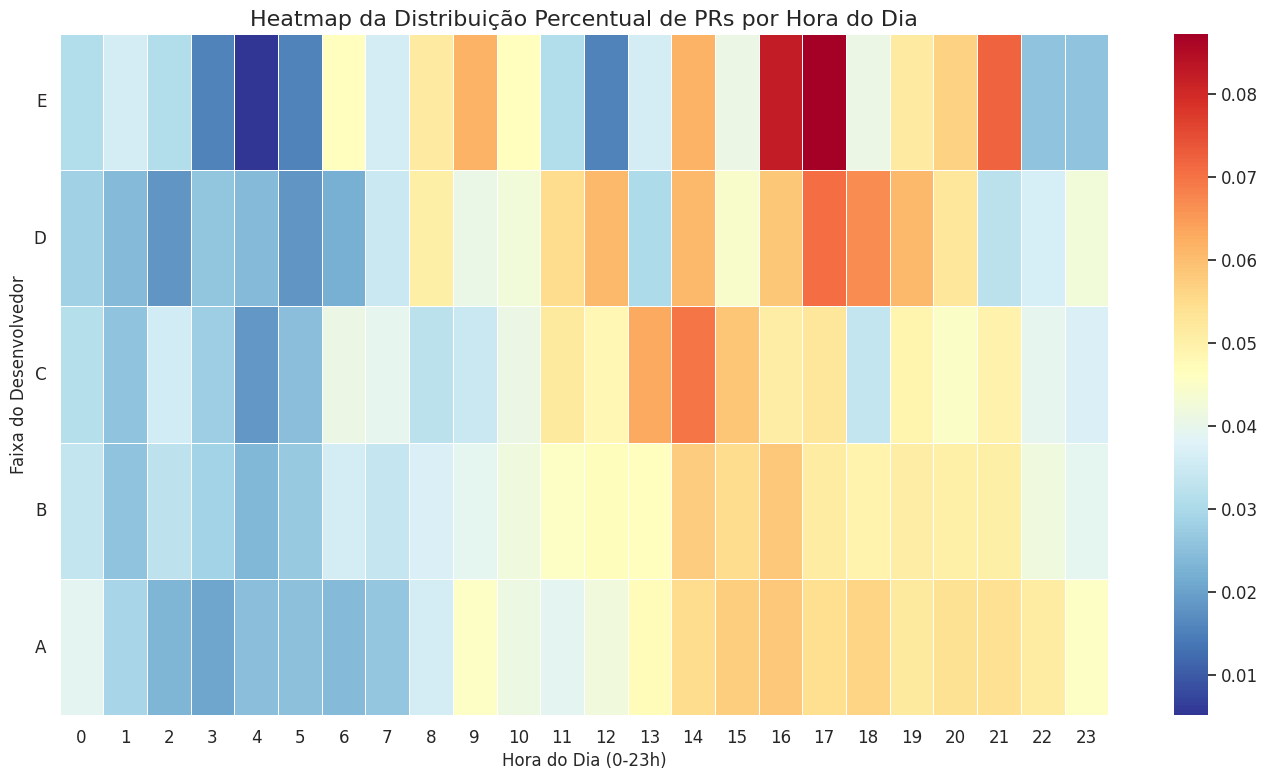

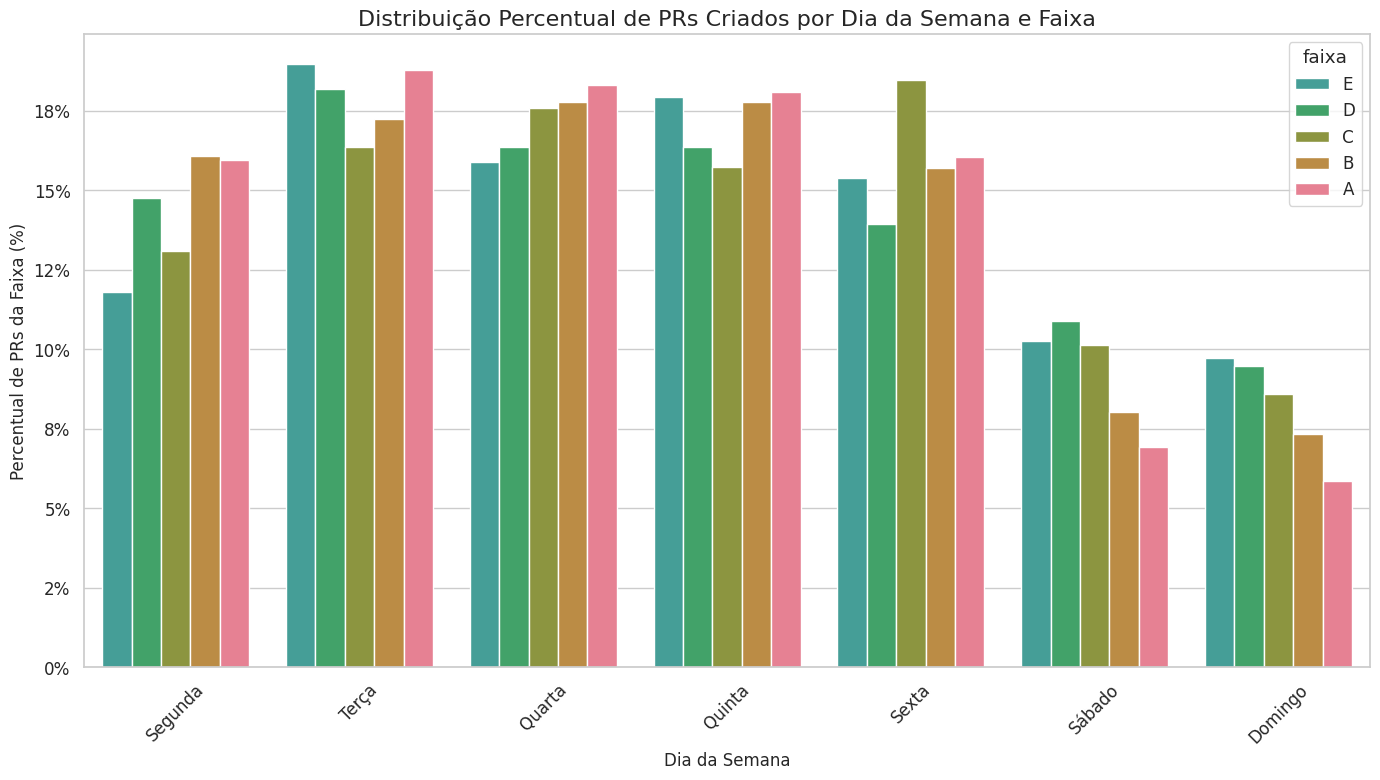

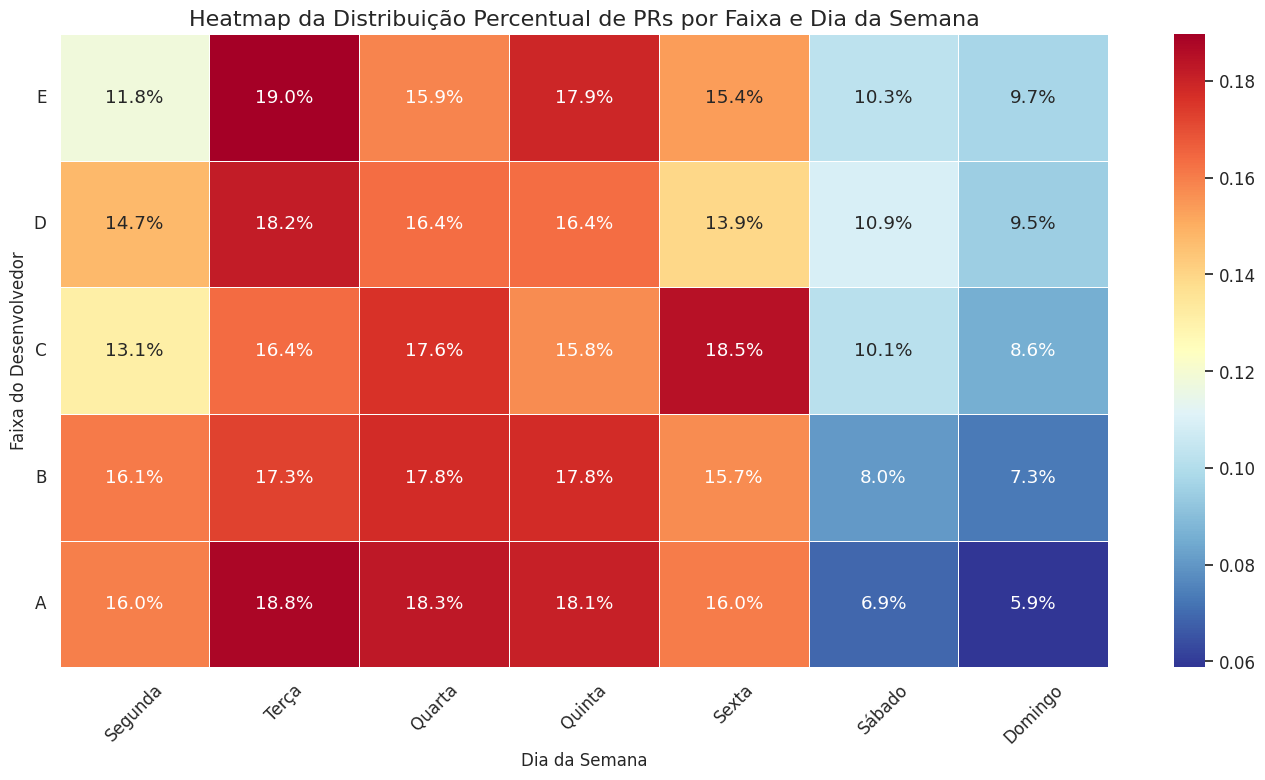


Análise finalizada.


In [9]:
import os
import json
import random
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Adicionado para melhor feedback visual

# --- 1. Configuração e Carregamento de Dados ---
# Caminho base
base_path = "repositories-mined"

# Armazenamento dos dados de PRs
todos_os_prs = []

print(f"Iniciando varredura em '{base_path}'...")

# Lista de repositórios para iterar com uma barra de progresso
# Adicionado um tratamento para caso o diretório não exista
if not os.path.isdir(base_path):
    print(f"Aviso: O diretório '{base_path}' não foi encontrado. O script será executado com dados de exemplo.")
    # Criando dados de exemplo para que o script possa ser executado
    faixas = ["A", "B", "C", "D", "E"]
    # Criando uma contagem assimétrica para testar a normalização
    contagem_faixas = {"A": 1000, "B": 800, "C": 600, "D": 300, "E": 100}
    prs_totais = sum(contagem_faixas.values())

    for i in range(prs_totais):
        # Seleciona uma faixa com base no peso definido
        faixa = random.choices(list(contagem_faixas.keys()), weights=list(contagem_faixas.values()), k=1)[0]

        # Simulando maior atividade durante a semana
        dia_semana = random.choices(range(7), weights=[10, 20, 25, 25, 15, 3, 2], k=1)[0]
        # Padrão de hora bimodal (picos de manhã e tarde)
        hora = int(random.choice([random.normalvariate(10, 1.5), random.normalvariate(15, 1.5)])) % 24
        created_at = datetime(2023, 1, 1 + dia_semana, hora, 0, 0).isoformat() + "Z"

        pr_exemplo = {
            'created_at': created_at,
            'merged_at': (datetime.fromisoformat(created_at.replace("Z", "+00:00")) + pd.Timedelta(hours=random.uniform(2, 72))).isoformat() + "Z",
            'ci_status_on_head': random.choices(["success", "failure", "pending"], weights=[70, 25, 5], k=1)[0],
            'faixa': faixa,
            'author': f'dev_{i}',
            'repo': 'repo_exemplo'
        }
        todos_os_prs.append(pr_exemplo)
else:
    repo_list = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    # Percorre cada repositório
    for repo in tqdm(repo_list, desc="Processando repositórios"):
        repo_path = os.path.join(base_path, repo)
        sample_path = os.path.join(repo_path, "sample-devs.jsonl")
        if not os.path.isfile(sample_path):
            continue
        devs_neste_repo = {}
        with open(sample_path, 'r', encoding='utf-8') as f:
            for line in f:
                dev_data = json.loads(line)
                devs_neste_repo[dev_data['author'].lower()] = dev_data['faixa']
        devs_folder_path = os.path.join(repo_path, "developer")
        if not os.path.isdir(devs_folder_path):
            continue
        for dev_name in os.listdir(devs_folder_path):
            if dev_name.lower() in devs_neste_repo:
                faixa = devs_neste_repo[dev_name.lower()]
                results_path = os.path.join(devs_folder_path, dev_name, "results")
                if not os.path.isdir(results_path):
                    continue
                for arquivo_json in os.listdir(results_path):
                    if not arquivo_json.endswith(".json"):
                        continue
                    caminho_arquivo = os.path.join(results_path, arquivo_json)
                    try:
                        with open(caminho_arquivo, 'r', encoding='utf-8') as f:
                            pr = json.load(f)
                        pr['author'] = dev_name
                        pr['faixa'] = faixa
                        pr['repo'] = repo
                        todos_os_prs.append(pr)
                    except Exception as e:
                        print(f"Aviso: Erro ao ler o arquivo {caminho_arquivo}: {e}")

print(f"\nTotal de PRs coletados: {len(todos_os_prs)}")

# --- 2. Análise de Eficiência e Processamento de Dados ---
def analisar_eficiencia(prs):
    registros = []
    for pr in prs:
        try:
            created_at = datetime.fromisoformat(pr['created_at'].replace("Z", "+00:00"))
        except (ValueError, TypeError):
            continue
        merged_at = pr.get("merged_at")
        tempo_merge = None
        if merged_at:
            try:
                merged = datetime.fromisoformat(merged_at.replace("Z", "+00:00"))
                tempo_merge = (merged - created_at).total_seconds() / 3600
            except (ValueError, TypeError):
                pass
        ci_status = pr.get("ci_status_on_head", "unknown")
        ci_sucesso = 1 if ci_status == "success" else 0
        ci_valido = ci_status in ["success", "failure", "pending"]
        registros.append({
            "faixa": pr["faixa"],
            "tempo_merge_horas": tempo_merge,
            "ci_status": ci_status,
            "ci_sucesso": ci_sucesso,
            "ci_valido": ci_valido,
            "hora_criacao": created_at.hour,
            "dia_semana_criacao": created_at.weekday(), # 0=Segunda, 6=Domingo
        })
    return pd.DataFrame(registros)

df = analisar_eficiencia(todos_os_prs)

# --- 3. Configuração de Visualização ---
ordem_faixas_original = ["A", "B", "C", "D", "E"]
ordem_e_ate_a = ["E", "D", "C", "B", "A"] # Ordem padrão para todos os gráficos

cores_husl = sns.color_palette("husl", 8)
paleta_consistente_husl = dict(zip(ordem_faixas_original, cores_husl))

sns.set(style="whitegrid", font_scale=1.1, rc={"figure.figsize": (14, 8)})


# --- 4. Geração e Exibição de Gráficos ---
def gerar_graficos(df):
    """
    Gera e exibe os gráficos da análise de eficiência, todos na ordem E -> A.
    """
    print("\n--- Gerando Gráficos de Análise de Eficiência (Ordem E -> A) ---")
    dias_semana_labels = ["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado", "Domingo"]

    # --- Gráfico 1: Tempo médio para merge ---
    plt.figure()
    sns.barplot(data=df, x='faixa', y='tempo_merge_horas',
                order=ordem_e_ate_a, errorbar='sd', palette=paleta_consistente_husl, capsize=.2)
    plt.title("Tempo Médio para Merge por Faixa (com Desvio Padrão)", fontsize=16)
    plt.xlabel("Faixa do Desenvolvedor", fontsize=12)
    plt.ylabel("Tempo para Merge (em horas)", fontsize=12)
    plt.show()

    # --- Gráfico 2: Taxa de sucesso da CI ---
    plt.figure()
    df_ci = df[df["ci_valido"]].groupby("faixa")["ci_sucesso"].mean().reindex(ordem_e_ate_a)
    sns.barplot(x=df_ci.index, y=df_ci.values, palette=paleta_consistente_husl)
    plt.title("Taxa de Sucesso da Integração Contínua (CI) por Faixa", fontsize=16)
    plt.xlabel("Faixa do Desenvolvedor", fontsize=12)
    plt.ylabel("Taxa de Sucesso (%)", fontsize=12)
    plt.ylim(0, 1)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.show()

    # ########################################################################## #
    # # --- NOVO GRÁFICO 3: Heatmap de Atividade por Hora do Dia ---             #
    # ########################################################################## #
    plt.figure()
    # 1. Pré-processamento para normalização por hora
    df_counts_hora = df.groupby(['faixa', 'hora_criacao']).size().reset_index(name='contagem')
    total_por_faixa = df.groupby('faixa').size().reset_index(name='total_faixa')
    df_norm_hora = pd.merge(df_counts_hora, total_por_faixa, on='faixa')
    df_norm_hora['proporcao'] = df_norm_hora['contagem'] / df_norm_hora['total_faixa']

    # 2. Pivotar e reordenar para o heatmap
    heatmap_pivot_hora = df_norm_hora.pivot_table(index='faixa', columns='hora_criacao', values='proporcao', fill_value=0)
    heatmap_pivot_hora = heatmap_pivot_hora.reindex(index=ordem_e_ate_a, columns=range(24)).fillna(0)

    # 3. Gerar o heatmap
    sns.heatmap(heatmap_pivot_hora,
                annot=False, # Anotações desativadas para não poluir o visual com 24 colunas
                fmt='.1%',
                cmap='RdYlBu_r', # Paleta Frio-Quente
                linewidths=.5)
    plt.title("Heatmap da Distribuição Percentual de PRs por Hora do Dia", fontsize=16)
    plt.xlabel("Hora do Dia (0-23h)", fontsize=12)
    plt.ylabel("Faixa do Desenvolvedor", fontsize=12)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- Pré-processamento para Gráficos de Dia da Semana ---
    df_counts_dia = df.groupby(['faixa', 'dia_semana_criacao']).size().reset_index(name='contagem')
    df_norm_dia = pd.merge(df_counts_dia, total_por_faixa, on='faixa')
    df_norm_dia['proporcao'] = df_norm_dia['contagem'] / df_norm_dia['total_faixa']

    # --- Gráfico 4a (NORMALIZADO): Proporção de PRs por Dia da Semana (Gráfico de Barras) ---
    plt.figure()
    sns.barplot(data=df_norm_dia,
                 x='dia_semana_criacao',
                 y='proporcao',
                 hue='faixa',
                 hue_order=ordem_e_ate_a,
                 palette=paleta_consistente_husl)
    plt.title("Distribuição Percentual de PRs Criados por Dia da Semana e Faixa", fontsize=16)
    plt.xlabel("Dia da Semana", fontsize=12)
    plt.ylabel("Percentual de PRs da Faixa (%)", fontsize=12)
    plt.xticks(ticks=range(7), labels=dias_semana_labels, rotation=45)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.tight_layout()
    plt.show()

    # --- Gráfico 4b (NORMALIZADO): Atividade de PRs por Dia da Semana (Heatmap) ---
    plt.figure()
    heatmap_pivot_dia = df_norm_dia.pivot_table(index='faixa', columns='dia_semana_criacao', values='proporcao', fill_value=0)
    heatmap_pivot_dia = heatmap_pivot_dia.reindex(index=ordem_e_ate_a, columns=range(7))

    sns.heatmap(heatmap_pivot_dia,
                annot=True,
                fmt='.1%',
                cmap='RdYlBu_r',
                linewidths=.5)
    plt.title("Heatmap da Distribuição Percentual de PRs por Faixa e Dia da Semana", fontsize=16)
    plt.xlabel("Dia da Semana", fontsize=12)
    plt.ylabel("Faixa do Desenvolvedor", fontsize=12)
    plt.xticks(ticks=[i + 0.5 for i in range(7)], labels=dias_semana_labels, rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# --- 5. Execução e Exibição de Resumos ---
if not df.empty:
    print("\n\n--- Resumo dos Dados (Ordem E -> A) ---")
    print("\n--- Tempo Médio para Merge por Faixa (em horas) ---")
    print(df.groupby('faixa')['tempo_merge_horas'].mean().reindex(ordem_e_ate_a).round(2))

    print("\n--- Taxa de Sucesso da CI por Faixa ---")
    print(df[df["ci_valido"]].groupby('faixa')['ci_sucesso'].mean().reindex(ordem_e_ate_a).round(3))

    print("\n--- Hora Média de Criação ---")
    print(df.groupby('faixa')['hora_criacao'].mean().reindex(ordem_e_ate_a).round(2))

    print("\n--- Dia Médio de Criação (0=Segunda) ---")
    print(df.groupby('faixa')['dia_semana_criacao'].mean().reindex(ordem_e_ate_a).round(2))

    print("\n--- Contagem Total de PRs por Faixa (para referência) ---")
    print(df.groupby('faixa').size().reindex(ordem_e_ate_a))

    gerar_graficos(df)
else:
    print("\nNenhum dado válido foi processado para gerar os gráficos.")

print("\nAnálise finalizada.")